In [3]:
import pandas as pd 
import fastai

df = pd.read_csv("downloads/40k_balanced_pm_acl.csv").sample(frac=1)
df = df.dropna(subset=["labels"])
df["text_nomask"] = df["text"] #backup
print(len(df))
df_test = df[:300]
df = df[300:]

fastai.__version__, len(df)

42140


('2.5.2', 41840)

In [20]:
df = df[df["text_length"] > 7]
len(df)

40474

In [21]:
from octoflow.core import replace_outof_vocab_words, vocab30k

df["text"] = df["text"].map(lambda t: replace_outof_vocab_words(t, vocab30k))
df_test["text"] = df_test["text"].map(lambda t: replace_outof_vocab_words(t,vocab30k))

In [22]:
df["text"] = df["text"].astype(str)
df["labels"] = df["labels"].astype(int)

In [24]:
df = df[(df["labels"] == 1) | (df["labels"] == 0)]
df["lab"] = df["labels"] #worst fastai bug in history

In [25]:
from fastai.text.all import *
dls = TextDataLoaders.from_df(df, text_col='text', label_col='lab')

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj for each of iicd herd sizes of iicd , iicd and iicd cattle , comparisons were made of the costs of iicd different control options ii : -lrb- i -rrb- xxmaj intensive dipping -lrb- iicd times iisym year -rrb- -lrb- ii -rrb- xxmaj intensive pour iihyph on iijj treatments -lrb- iicd times iisym year -rrb- -lrb- xxrep 3 i -rrb- iinnp iinn with strategic dipping -lrb- iicd times iisym year -rrb- -lrb- iv -rrb- iinnp iinn with pour iihyph on treatment -lrb- iicd times iisym year -rrb- xxmaj it is concluded from these studies that , on farms where iinn is a serious problem , iinn coupl...",1
1,"xxbos -lrb- xxmaj first xxmaj nations is the term commonly used in xxmaj canada to describe the various societies of indigenous peoples who are xxunk status as ii ` ` xxmaj indians ii '' by the xxmaj indian xxmaj act of iicd and who are not of xxmaj inuit or iinnp descent . -rrb- xxmaj along with a lack of adequate funding to address human and environmental issues ii : as well as past industrial exploitation of xxmaj first xxmaj nations lands ii , the safety and iinn of many solid waste management practices in xxmaj canadian xxmaj first xxmaj nations communities have become a serious conce...",1
2,"xxbos xxmaj we iirb iivbd iicd iinn -lrb- iixx iicd weeks -rrb- infants to receive either conventional therapy of continuous positive airway pressure -lrb- iinnp -rrb- at iicd ii_sp cm iinn , or four groups of iinnp plus a single maneuver of xxup sli at four regimens based on administered pressures and durations ; iinnp -lrb- xxmaj pressure of iicd ii_sp cm iinn for a duration of iicd seconds -rrb- , iinnps -lrb- iicd ii_sp cm iinn for iicd seconds -rrb- , iinnp -lrb- iicd ii_sp cm iinn for iicd seconds -rrb- , and iinns -lrb- iicd ii_sp cm iinn for iicd seconds -rrb- using a t iihyph piec...",0
3,"xxbos xxmaj this study found that -lrb- iils -rrb- the journals related to xxmaj respiratory xxmaj care are easily presented on xxmaj google xxmaj maps ; -lrb- iicd -rrb- iicd journal clusters were identified using xxup sna ; -lrb- iils -rrb- the top iicd mesh terms are methods , therapy , and xxunk , and -lrb- iils -rrb- the odds ratios of mesh terms between journals associated with the xxmaj respiratory xxmaj care showing different from xxmaj int j xxwrep 3 iinnp xxmaj dis and similar to xxmaj xxunk iinnp iinnp xxmaj diabetes iinnps within heterogeneity with iiadd iisym iicd .",0
4,"xxbos xxmaj examples are iijj clauses ii , these are an old xxmaj indo iihyph xxmaj european feature which most modern xxmaj european languages have lost ii : , extensive use of complex iinn , and rampant pro iijj drop . using only those iinnps that exactly match clean lists leaves out some good data -lrb- iirb , a tuple with an iinn of ii ` ` xxmaj univ of xxmaj wash ii '' will not match against a list of universities that spells it as ii ` ` xxmaj university of xxmaj washington ii '' -rrb-",0
5,"xxbos xxmaj the persistent street children differed greatly from those who entered the iinn , most markedly in their higher risk of police abuse -lrb- iicd iinn versus iicd iinn -rrb- , absence from school -lrb- iicd iinn versus iicd iinn -rrb- , engagement in xxunk -lrb- iicd iinn versus iicd iinn -rrb- , xxunk thinner use -lrb- iicd iinn versus iicd iinn -rrb- , alcohol use -lrb- iicd iinn versus iicd iinn -rrb- , and a serious medical problem -lrb- iicd iinn versus iicd iinn -rrb- .",1
6,"xxbos xxmaj our current in xxmaj mexico is that it represents a serious health problem not yet recognized as low iihyph energy fractures in older adults account for approximately iicd iinn of subjects over iicd years -lrb- compared with iicd iinn in xxmaj japan -rrb- about iicd million fractures in patients over iicd years , taking into account that we are a nation of iicd million , the problem is minor compared with other diseases in this and other population groups .",1
7,"xxbos xxmaj we conducted a iivbn controlled trial with two groups ii : control group -lrb- n

epoch     train_loss  valid_loss  accuracy  fbeta_score  time    
0         0.190869    0.113108    0.958117  0.960522     00:18     
epoch     train_loss  valid_loss  accuracy  fbeta_score  time    
0         0.060396    0.041090    0.986533  0.987309     00:24     
1         0.039011    0.036075    0.986286  0.987124     00:24     


,text,category,category_
0,"xxbos xxmaj this observational study reviews data on the number of cases of iinns identified by each of the five iinns detection approaches ii : iils -rrb- passive iinns detection at local clinics after staff attended xxmaj neglected xxmaj tropical xxmaj disease awareness workshops , iicd -rrb- community iihyph based case detection carried out in remote communities by hospital staff who relied on community health workers to identify cases , iicd -rrb- iinns screening following mass iinnp xxmaj ulcer outreach programs being xxunk in the district , iicd -rrb- school iihyph based screening pr...",0,0
1,"xxbos randomized , prospective single center study , primary setting ; iicd patients with moderate chronic iinn with iinns -lrb- iinnp -rrb- , corresponding to a xxmaj lund iisym xxmaj xxunk score of iicd iisym iicd ; home based iinnp therapy -lrb- xxup est -rrb- with amplitude iivbd current -lrb- base frequency of iicd xxmaj hz , frequency band of iicd iisym iicd xxmaj hz -rrb- over iicd weeks iirb to a concurrent iinn therapy with topical iinns ; measurement of nasal nitric oxide concentration and self iihyph assessment of complaints with the questionnaire instrument iinn iinnp ; survey ...",0,0
2,"xxbos xxmaj we present a novel idea for overcoming the drawback of poor contact between the iinn cathode and active layer interface in an inverted polymer solar cell -lrb- i iihyph xxup psc -rrb- , simply by incorporating an electron iihyph iinn self iihyph assembled iinn -lrb- iijj acid -lrb- iinnp the iinn cathode surface to create an electron iihyph poor surface of iinnp on iinnp xxmaj the iinnp molecules on iinn are anchored on the iinn surface by reacting its iinn groups with iinnp groups on the iinn surface , such that the iijj iinns lay on the surface with plane iihyph on electron i...",1,1
3,"xxbos xxmaj the study included iicd patients with xxmaj american xxmaj society of iinnps iipos -lrb- xxup asa -rrb- class i and xxup ii , in good iijj health , who were assigned to one of three groups ii : xxmaj restrictive group , which received iicd ml iisym kg iisym hr iirb and six hours iirb ; xxmaj low liberal group , which received iicd ml iisym kg iisym hr of xxmaj ringer iipos solution iirb and six hours iijj and xxmaj high liberal group , which received iicd ml iisym kg iisym hr iirb and iicd ml iisym kg iisym hr six hours iirb .",0,0
4,"xxbos xxmaj in this single iihyph dose , open iihyph label , crossover study , healthy adults -lrb- age range , iicd iisym iicd years -rrb- were iivbn equally to one of six treatment sequences for three iicd iihyph hour treatment periods with iinnp -lrb- iinn iicd iinnp iihyph iinn iicd iinnps -rrb- , the iinnp iinnp iinn component of iinnp -lrb- xxup mf iihyph xxunk , iicd iinn -rrb- , and iinnp xxmaj food and xxmaj drug xxmaj administration iihyph approved iinn -lrb- xxup mf , iicd iinn -rrb- ; all the treatments were administered as two xxunk per iinn .",0,0
5,"xxbos xxmaj vaccines for xxup sars , iinnp and iinnp have never been approved , and the data generated in the development and testing of these vaccines suggest a serious iijj concern ii : that vaccines designed iirb using the traditional approach -lrb- consisting of the iijj or minimally modified iinn viral spike to elicit iijj antibodies -rrb- , be they composed of protein , viral vector , xxup dna or xxup rna and irrespective of delivery method , may iivb iinnp disease via antibody iihyph dependent enhancement -lrb- xxup xxunk -rrb- .",1,1
6,"xxbos xxmaj the median ii - lrb- iinn range ii - rrb- tidal volume was lower with vs without nasal passage iinn at iicd cm h iixx iinnp iinfp o iinn pressure -lrb- iicd ii - lrb- iicd iisym iicd ii - rrb- ml vs iicd ii - lrb- iicd iisym iicd ii - rrb- ml , respectively ; median difference -lrb- xxup md -rrb- , iicd ml ; iicd iinn confidence interval -lrb- xxup ci -rrb- , iicd to iicd ; p iixx iicd .",0,0
7,"xxbos xxmaj there were no differences in the iinnp iihyph indu

,input,target,predicted,probability,loss
0,xxbos a limitation of the study is that observational studies can not establish iinn .,0,1,0.9999760389328003,10.638762474060059
1,xxbos xxmaj type iicd xxup dm is rapidly rising as a global health care problem that threatens to reach pandemic levels by iicd .,0,1,0.9988815188407898,6.795788288116455
2,xxbos iijj foreign body aspiration is a life iihyph threatening emergency .,0,1,0.9978442192077637,6.139606952667236


('0', tensor(0), tensor([0.9816, 0.0184]))

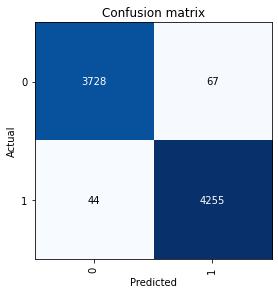

In [26]:
dls.show_batch()

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])
learn.fine_tune(2, 1e-2)
learn.show_results()


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3)  
interp.plot_confusion_matrix()

learn.predict("We discuss the implications of a more 'civic-minded journalism.")

In [27]:
learn.fine_tune(2, 1e-2)


epoch     train_loss  valid_loss  accuracy  fbeta_score  time    
0         0.035074    0.040518    0.986410  0.987191     00:18     
epoch     train_loss  valid_loss  accuracy  fbeta_score  time    
0         0.039080    0.041482    0.986904  0.987683     00:24     
1         0.027735    0.037704    0.987398  0.988145     00:24     


In [38]:
learn.export('oct15_40k.pkl')
learn.save("oc15_40k")

Path('models/oc15_40k.pth')

## Sanity Check: Tough Cases
0 = non-problem
1 = problem

In [29]:
learn.predict("Anaphylaxis is a life-threatening emergency of which reliable epidemiological data are lacking")

('0', tensor(0), tensor([0.8883, 0.1117]))

In [46]:
predicts = df_test["text"].map(learn.predict)

In [47]:
df_test["predicted"] = [int(p[0]) for p in predicts]
df_test["confidence_0"] =  [round(p[2][0].item(),2) for p in predicts]
df_test["confidence_1"] =  [round(p[2][1].item(),2) for p in predicts]

In [48]:
df_test.to_csv("downloads/oct15_40k_test300.csv")

In [ ]:
print("accuracy in test set:", len(df_test[df_test["predicted"] == df_test["labels"]])/len(df_test))

accuracy in test set: 0.8966666666666666


In [ ]:
predicts2 = df_test["text_nomask"].map(learn.predict)

In [ ]:
df_test["predicted2"] = [int(p[0]) for p in predicts2]
print("accuracy in test set with no masking:", len(df_test[df_test["predicted2"] == df_test["labels"]])/len(df_test))

accuracy in test set with no masking: 0.8966666666666666


That's very weird ... masking doesn't effect predictions